# NDMI data analysis

Data wrangling for NDMI data.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


2023-02-06 20:42:47 Configured OSMnx 1.1.2
2023-02-06 20:42:47 HTTP response caching is on


## Download data

### NDMI data

In [3]:
ndmi_schema = 'raster_analysis'
ndmi_folder = 'ndvi_analysis_hex'

r = 10

query = f'SELECT * FROM {ndmi_schema}.{ndmi_folder} WHERE \"res\" = {r}'

ndmi = aup.gdf_from_query(query, geometry_col='geometry')
print(ndmi.shape)
ndmi.head(2)

(58163, 8)


,hex_id,geometry,res,ndvi_mean,ndvi_max,ndvi_min,ndvi_diff,city
0,8a49abc9c697fff,"POLYGON ((-103.61748 20.42272, -103.61683 20.4...",10,0.319575,0.682218,0.140721,0.541497,Guadalajara
1,8a49abc9ea47fff,"POLYGON ((-103.61554 20.42404, -103.61490 20.4...",10,0.442342,0.787857,0.092851,0.695006,Guadalajara


### Marginalization

In [4]:
mun_schema = 'metropolis'
mun_folder = 'metro_gdf'

city = 'Guadalajara'

query = f"SELECT * FROM {mun_schema}.{mun_folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(10, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,14002,14,002,Acatlán de Juárez,"POLYGON ((-103.65448 20.50346, -103.65200 20.5...",Guadalajara
1,14039,14,039,Guadalajara,"POLYGON ((-103.31164 20.75098, -103.31014 20.7...",Guadalajara


In [5]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())

In [6]:
# donwload hexagons with pop data
hex_marg = gpd.GeoDataFrame()
hex_folder = 'hex_bins_marg_2020'
hex_schema = 'censo'


# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_marg = pd.concat([hex_marg, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_marg.shape)
hex_marg.head(2)

(1163, 17)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",8849abc9ebfffff,14002,273.168550,0.474944,2.828432,1.787101,0.1098,0.008903,0.115735,0.029676,0.697379,4.282201,0.593514,2.756871,120.556725,0.941744
1,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",8849abc9e3fffff,14002,89.333336,1.282051,7.092198,7.960199,0.0000,0.000000,0.621891,0.000000,1.492537,15.049751,0.373134,8.333333,122.339516,0.955670


## Data analysis

### Univariate analysis

In [7]:
raster_idx = 'ndvi'

<AxesSubplot: xlabel='ndvi_mean', ylabel='Count'>

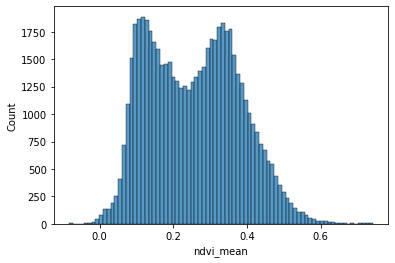

In [8]:
sns.histplot(ndmi[f'{raster_idx}_mean'])

<AxesSubplot: >

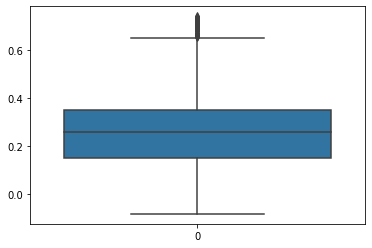

In [9]:
sns.boxplot(data=ndmi[f'{raster_idx}_mean'])

<AxesSubplot: >

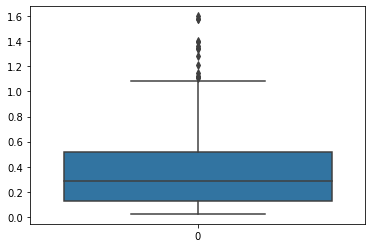

In [10]:
sns.boxplot(data=ndmi[f'{raster_idx}_diff'])

Mean

In [11]:
ndmi[f'{raster_idx}_mean'].mean()

0.2566256130423989

Standar deviation

In [12]:
ndmi[f'{raster_idx}_mean'].std()

0.12333830088898974

Median

In [13]:
ndmi[f'{raster_idx}_mean'].median()

0.257044642930486

Difference mean

In [14]:
ndmi[f'{raster_idx}_diff'].mean()

0.325699396873306

<AxesSubplot: >

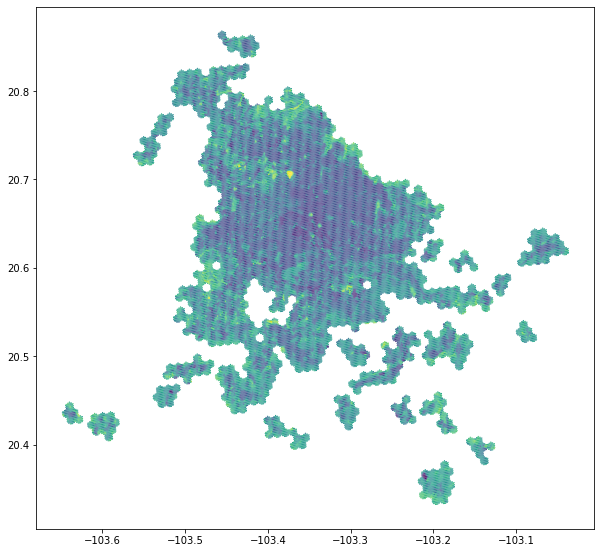

In [32]:
fig,ax = plt.subplots(figsize=(10,10))

ndmi.plot(f'{raster_idx}_mean', ax=ax)

In [34]:
ndmi[['hex_id','res','ndvi_mean',
     'ndvi_min','ndvi_max','ndvi_diff',
     'city','geometry']].to_file('../../data/processed/satellite_image/ndvi_amg_hexres10.geojson')

### Bivariate

#### Pretreatment

In [15]:
ndmi_cnt = ndmi[['hex_id','geometry']].copy()
ndmi_cnt = ndmi_cnt.to_crs("EPSG:6372")
ndmi_cnt['geometry'] = ndmi_cnt.centroid
ndmi_cnt = ndmi_cnt.to_crs("EPSG:4326")

In [16]:
ndmi_cnt_marg = ndmi_cnt.overlay(hex_marg)
ndmi_cnt_marg.head(2)

,hex_id,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020,geometry
0,8a49abc9c697fff,8849abc9ebfffff,14002,273.16855,0.474944,2.828432,1.787101,0.1098,0.008903,0.115735,0.029676,0.697379,4.282201,0.593514,2.756871,120.556725,0.941744,POINT (-103.61756 20.42347)
1,8a49abc9ea47fff,8849abc9ebfffff,14002,273.16855,0.474944,2.828432,1.787101,0.1098,0.008903,0.115735,0.029676,0.697379,4.282201,0.593514,2.756871,120.556725,0.941744,POINT (-103.61562 20.42478)


In [17]:
ndmi = ndmi.merge(ndmi_cnt_marg[['hex_id','imn_2020']], on='hex_id')

#### Analysis

<AxesSubplot: xlabel='imn_2020', ylabel='ndvi_mean'>

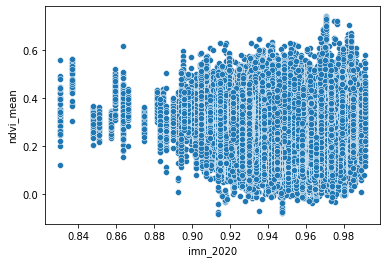

In [18]:
sns.scatterplot(data=ndmi, x="imn_2020", y=f'{raster_idx}_mean')

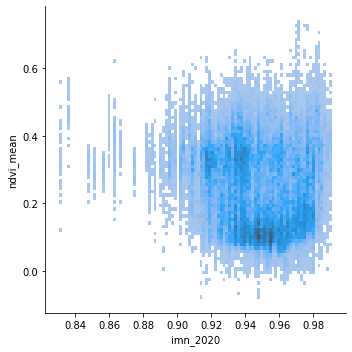

In [19]:
sns.displot(ndmi, x="imn_2020", y=f'{raster_idx}_mean')

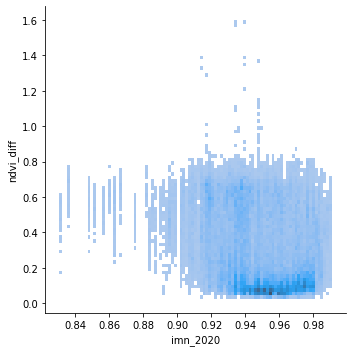

In [20]:
sns.displot(ndmi, x="imn_2020", y=f'{raster_idx}_diff')

In [21]:
ndmi['Grado_Marg'] = np.nan
ndmi.loc[ndmi.imn_2020>=0.966338 , 'Grado_Marg'] = 'Muy bajo'
ndmi.loc[(ndmi.imn_2020>=0.946436 )&
             (ndmi.imn_2020<0.966338), 'Grado_Marg'] = 'Bajo'
ndmi.loc[(ndmi.imn_2020>=0.926536)&
             (ndmi.imn_2020<0.946436), 'Grado_Marg'] = 'Medio'
ndmi.loc[(ndmi.imn_2020>=0.8999)&
             (ndmi.imn_2020<0.926536), 'Grado_Marg'] = 'Alto'
ndmi.loc[ndmi.imn_2020 < 0.8999, 'Grado_Marg'] = 'Muy alto'

In [22]:
from pandas.api.types import CategoricalDtype


In [23]:
#categorical data
cat_list = ['Muy bajo','Bajo','Medio','Alto', 'Muy alto']

cat_size_order = CategoricalDtype(
    cat_list, 
    ordered=True)

ndmi['Grado_Marg'] = ndmi['Grado_Marg'].astype(cat_size_order)
ndmi = ndmi.sort_values('Grado_Marg')

Text(0, 0.5, 'NDVI')

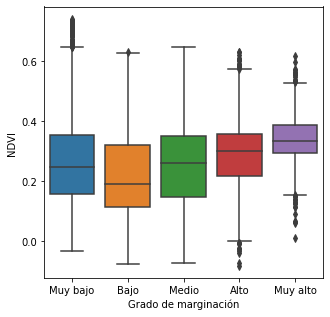

In [25]:
fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(x=np.array(ndmi.Grado_Marg) , y=np.array(ndmi[f'{raster_idx}_mean']), ax=ax)

plt.xlabel('Grado de marginación')
plt.ylabel('NDVI')

In [26]:
ndmi.groupby('Grado_Marg').mean()

/tmp/ipykernel_5024/1678047877.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ndmi.groupby('Grado_Marg').mean()


,res,ndvi_mean,ndvi_max,ndvi_min,ndvi_diff,imn_2020
Grado_Marg,,,,,,
Muy bajo,10.0,0.262098,0.411075,0.132975,0.278100,0.975612
Bajo,10.0,0.218520,0.367274,0.103249,0.264025,0.955853
Medio,10.0,0.256631,0.455879,0.115596,0.340282,0.936889
Alto,10.0,0.289493,0.542115,0.122480,0.419635,0.917424
Muy alto,10.0,0.341055,0.636612,0.129508,0.507104,0.879075


Text(0, 0.5, 'NDMI Difference')

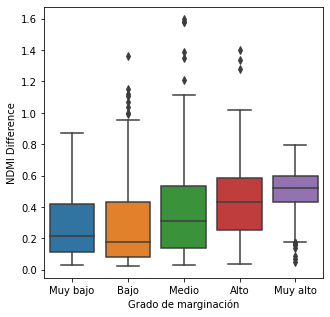

In [27]:
fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(x=np.array(ndmi.Grado_Marg) , y=np.array(ndmi[f'{raster_idx}_diff']), ax=ax)

plt.xlabel('Grado de marginación')
plt.ylabel('NDMI Difference')

### Spatial autocorrelation

In [28]:
import esda
import pysal
import libpysal as lps
from splot import esda as esdaplot

In [30]:
column_analysis = f'{raster_idx}_mean'

In [31]:
wq =  lps.weights.Queen.from_dataframe(ndmi)
wq.transform = 'r'

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  warnings.warn(message)


In [37]:
y = ndmi[column_analysis]
ylag = lps.weights.lag_spatial(wq, y)

In [38]:
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(ndmi)
wq.transform = 'b'
np.random.seed()
jc = esda.join_counts.Join_Counts(yb, wq)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  warnings.warn(message)


Text(0.5, 0, 'BB Counts')

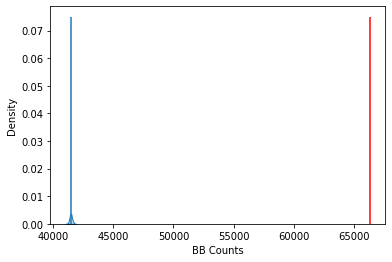

In [39]:
sns.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

In [40]:
mi = esda.moran.Moran(y, wq)

Text(0.5, 0, "Moran's I")

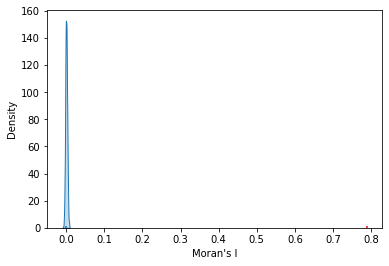

In [41]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [42]:
wq.transform = 'r'
lag_time = lps.weights.lag_spatial(wq, ndmi[column_analysis])

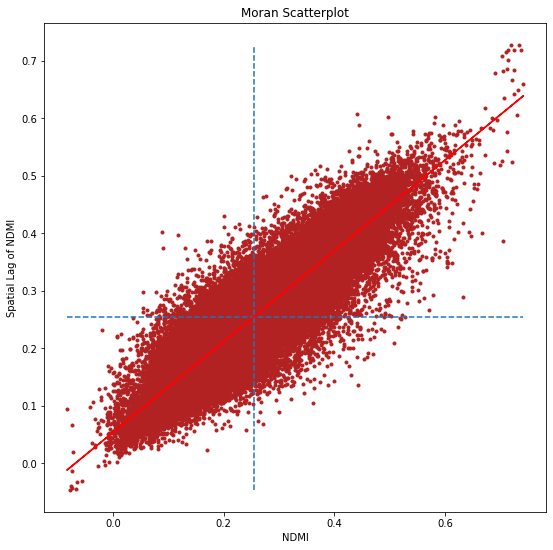

In [43]:
time = ndmi[column_analysis]
b, a = np.polyfit(time, lag_time, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(time, lag_time, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(time.mean(), lag_time.min(), lag_time.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_time.mean(), time.min(), time.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(time, a + b*time, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of NDMI')
plt.xlabel('NDMI')
plt.show()

In [44]:
wq = lps.weights.distance.Kernel.from_dataframe(ndmi[[column_analysis,'geometry']])

li = esda.moran.Moran_Local(y, wq)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  warnings.warn(message)


In [45]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond

In [46]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

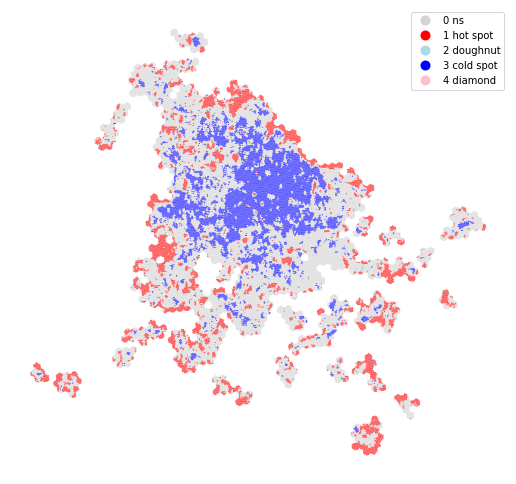

In [47]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
ndmi.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [48]:
ndmi['label_mean'] = np.array(labels)

In [49]:
lisa = esda.moran.Moran_Local(ndmi[column_analysis], wq)

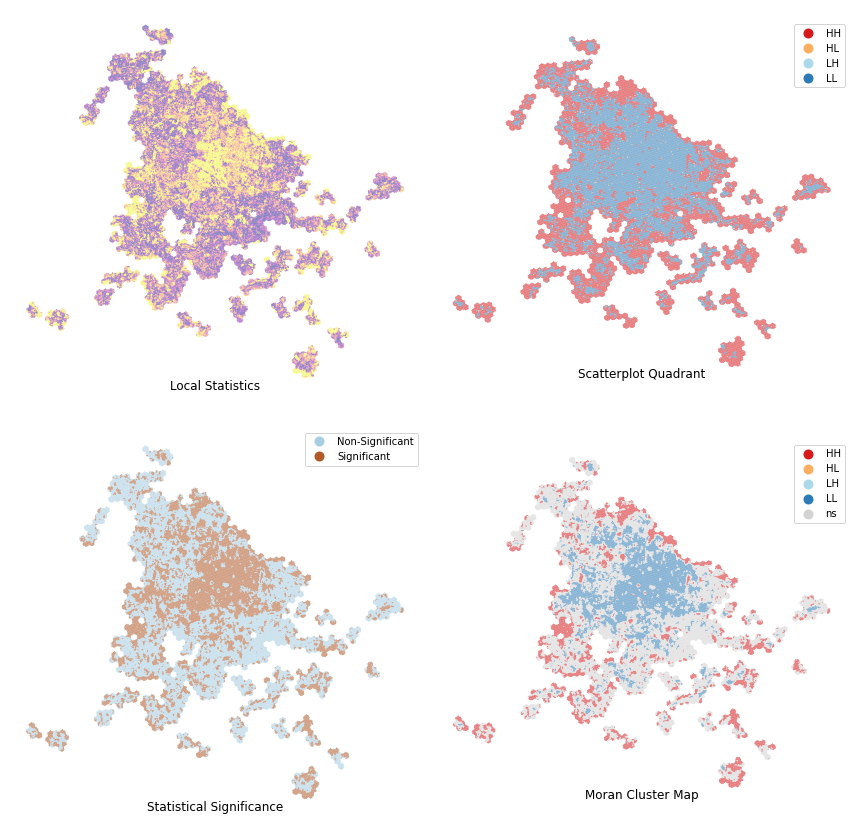

In [50]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
            # Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
ndmi.assign(
    Is=lisa.Is
# Plot choropleth of local statistics
).plot(
    column='Is', 
    cmap='plasma', 
    scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=False,
    ax=ax
)

                    # Subplot 2 #
                # Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, ndmi, p=1, ax=ax);

                    # Subplot 3 #
                # Significance map
# Grab third axis of local statistics
ax = axs[2]
# 
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), # Assign 1 if significant, 0 otherwise
    index=ndmi.index           # Use the index in the original data
# Recode 1 to "Significant and 0 to "Non-significant"
).map({1: 'Significant', 0: 'Non-Significant'})
# Assign labels to `db` on the fly
ndmi.assign(
    cl=labels
# Plot choropleth of (non-)significant areas
).plot(
    column='cl', 
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

                       
                    # Subplot 4 #
                    # Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, ndmi, p=0.05, ax=ax);

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Local Statistics', 
            'Scatterplot Quadrant', 
            'Statistical Significance', 
            'Moran Cluster Map'
        ][i], y=0
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()


### NDMI Difference

In [78]:
column_analysis = 'ndmi_diff'

In [79]:
wq =  lps.weights.Queen.from_dataframe(ndmi)
wq.transform = 'r'

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  warnings.warn(message)


In [80]:
y = ndmi[column_analysis]
ylag = lps.weights.lag_spatial(wq, y)

In [81]:
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(ndmi)
wq.transform = 'b'
np.random.seed()
jc = esda.join_counts.Join_Counts(yb, wq)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  warnings.warn(message)


Text(0.5, 0, 'BB Counts')

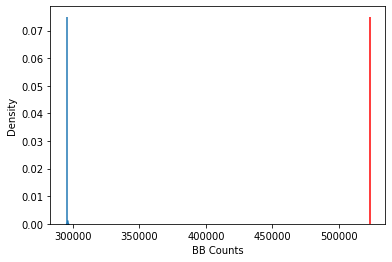

In [82]:
sns.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

In [83]:
mi = esda.moran.Moran(y, wq)

Text(0.5, 0, "Moran's I")

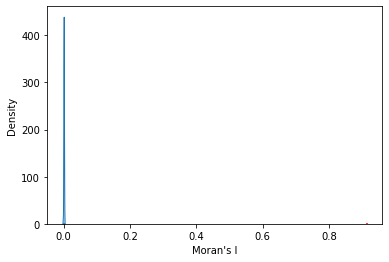

In [84]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [85]:
wq.transform = 'r'
lag_time = lps.weights.lag_spatial(wq, ndmi[column_analysis])

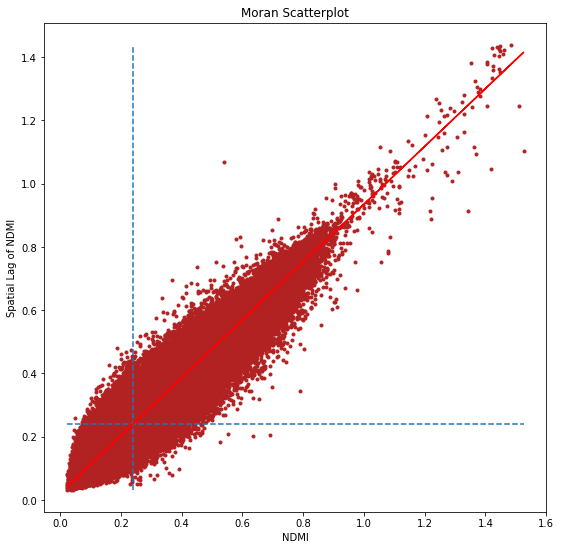

In [86]:
time = ndmi[column_analysis]
b, a = np.polyfit(time, lag_time, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(time, lag_time, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(time.mean(), lag_time.min(), lag_time.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_time.mean(), time.min(), time.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(time, a + b*time, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of NDMI')
plt.xlabel('NDMI')
plt.show()

In [87]:
wq = lps.weights.distance.Kernel.from_dataframe(ndmi[[column_analysis,'geometry']])

li = esda.moran.Moran_Local(y, wq)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  warnings.warn(message)


In [88]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond

In [89]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

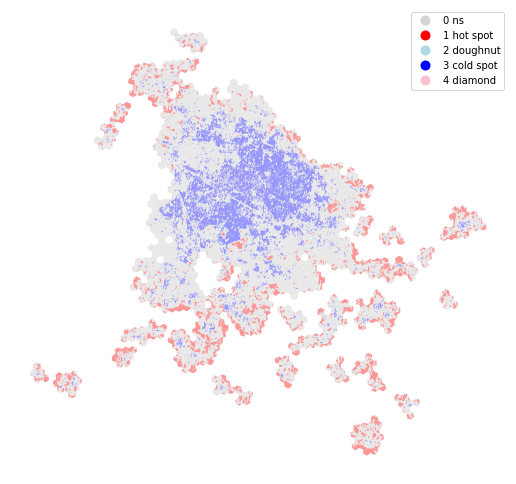

In [90]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
ndmi.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [91]:
ndmi['label_diff'] = np.array(labels)

In [61]:
lisa = esda.moran.Moran_Local(ndmi[column_analysis], wq)

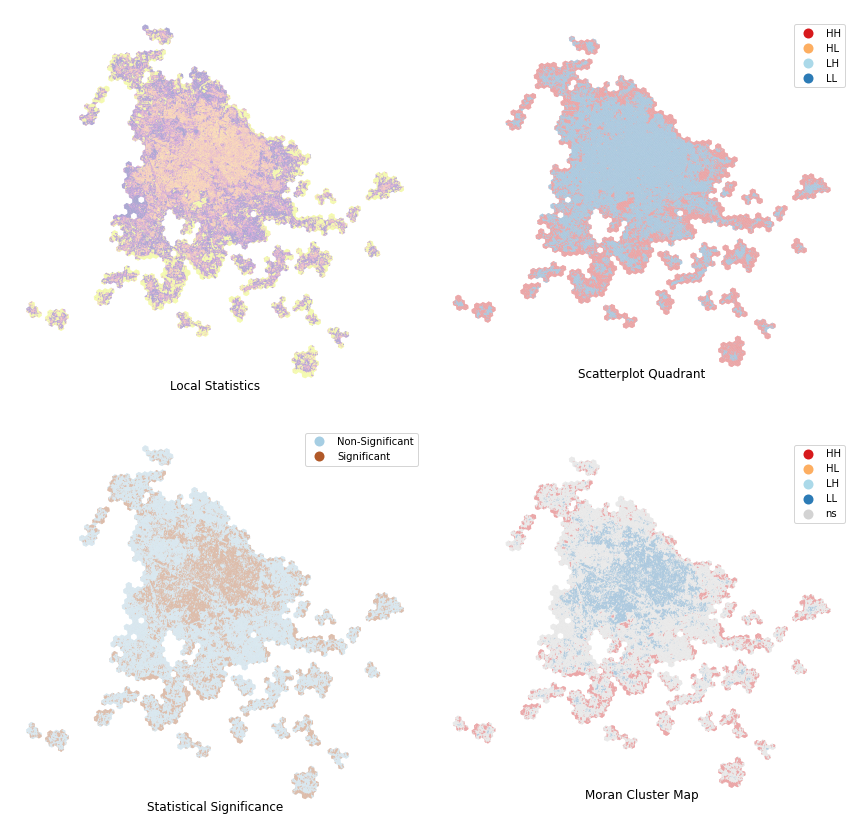

In [62]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
            # Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
ndmi.assign(
    Is=lisa.Is
# Plot choropleth of local statistics
).plot(
    column='Is', 
    cmap='plasma', 
    scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=False,
    ax=ax
)

                    # Subplot 2 #
                # Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, ndmi, p=1, ax=ax);

                    # Subplot 3 #
                # Significance map
# Grab third axis of local statistics
ax = axs[2]
# 
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), # Assign 1 if significant, 0 otherwise
    index=ndmi.index           # Use the index in the original data
# Recode 1 to "Significant and 0 to "Non-significant"
).map({1: 'Significant', 0: 'Non-Significant'})
# Assign labels to `db` on the fly
ndmi.assign(
    cl=labels
# Plot choropleth of (non-)significant areas
).plot(
    column='cl', 
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

                       
                    # Subplot 4 #
                    # Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, ndmi, p=0.05, ax=ax);

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Local Statistics', 
            'Scatterplot Quadrant', 
            'Statistical Significance', 
            'Moran Cluster Map'
        ][i], y=0
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()


In [92]:
ndmi

,hex_id,geometry,res,ndmi_mean,ndmi_max,ndmi_min,ndmi_diff,city,imn_2020,Grado_Marg,label,label_mean,label_diff
121593,8b49aa2cd51efff,"POLYGON ((-103.37919 20.56071, -103.37902 20.5...",11,-0.065527,0.483448,-0.236249,0.719697,Guadalajara,0.970472,Muy bajo,0 ns,0 ns,0 ns
359344,8b498c96db68fff,"POLYGON ((-103.41514 20.66887, -103.41497 20.6...",11,0.006983,0.052705,-0.026246,0.078951,Guadalajara,0.978744,Muy bajo,3 cold spot,0 ns,3 cold spot
359345,8b498c96db0efff,"POLYGON ((-103.41116 20.66781, -103.41099 20.6...",11,0.014121,0.060825,-0.009991,0.070816,Guadalajara,0.978744,Muy bajo,3 cold spot,0 ns,3 cold spot
359346,8b498c96db86fff,"POLYGON ((-103.40704 20.66821, -103.40687 20.6...",11,0.014485,0.055141,-0.012723,0.067864,Guadalajara,0.978744,Muy bajo,3 cold spot,0 ns,3 cold spot
359347,8b498c96db49fff,"POLYGON ((-103.41499 20.67033, -103.41482 20.6...",11,0.031301,0.147906,-0.078096,0.226002,Guadalajara,0.978744,Muy bajo,0 ns,0 ns,0 ns
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336887,8b49ab4928b5fff,"POLYGON ((-103.36607 20.79264, -103.36590 20.7...",11,-0.109173,0.043977,-0.212641,0.256618,Guadalajara,0.895417,Muy alto,0 ns,3 cold spot,0 ns
336888,8b49ab492836fff,"POLYGON ((-103.36849 20.79113, -103.36832 20.7...",11,-0.002940,0.126913,-0.140009,0.266922,Guadalajara,0.895417,Muy alto,0 ns,0 ns,0 ns
336889,8b49ab4928e6fff,"POLYGON ((-103.36953 20.79440, -103.36935 20.7...",11,-0.025533,0.128457,-0.091490,0.219947,Guadalajara,0.895417,Muy alto,0 ns,0 ns,0 ns
336891,8b49ab492971fff,"POLYGON ((-103.37267 20.79024, -103.37249 20.7...",11,0.073468,0.222239,-0.048813,0.271052,Guadalajara,0.895417,Muy alto,0 ns,0 ns,0 ns


<AxesSubplot: >

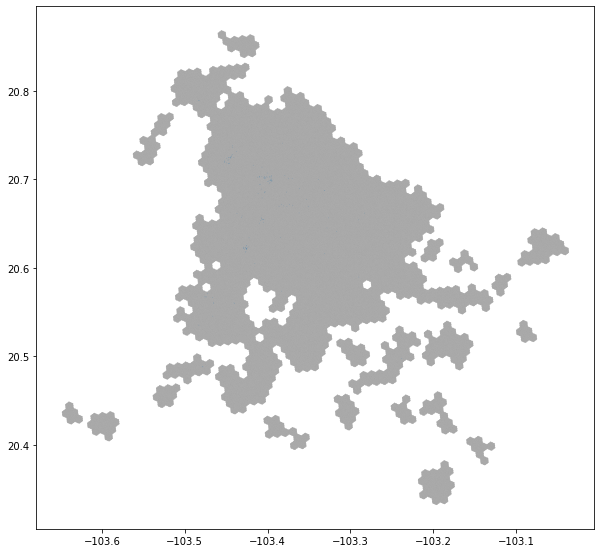

In [94]:
fig,ax = plt.subplots(figsize=(10,10))

ndmi.loc[(ndmi.label_mean=='1 hot spot')&
        (ndmi.label_diff=='3 cold spot')].plot(ax=ax, zorder=2, alpha=0.75)
ndmi.plot(ax=ax, color='grey', zorder=1)

## Distribution analysis

In [105]:
ndmi.loc[(ndmi.ndmi_mean>=ndmi.ndmi_mean.mean())&
        (ndmi.label_diff=='3 cold spot')]

,hex_id,geometry,res,ndmi_mean,ndmi_max,ndmi_min,ndmi_diff,city,imn_2020,Grado_Marg,label,label_mean,label_diff
359344,8b498c96db68fff,"POLYGON ((-103.41514 20.66887, -103.41497 20.6...",11,0.006983,0.052705,-0.026246,0.078951,Guadalajara,0.978744,Muy bajo,3 cold spot,0 ns,3 cold spot
359345,8b498c96db0efff,"POLYGON ((-103.41116 20.66781, -103.41099 20.6...",11,0.014121,0.060825,-0.009991,0.070816,Guadalajara,0.978744,Muy bajo,3 cold spot,0 ns,3 cold spot
359346,8b498c96db86fff,"POLYGON ((-103.40704 20.66821, -103.40687 20.6...",11,0.014485,0.055141,-0.012723,0.067864,Guadalajara,0.978744,Muy bajo,3 cold spot,0 ns,3 cold spot
359348,8b498c96db16fff,"POLYGON ((-103.40899 20.66690, -103.40881 20.6...",11,0.015561,0.050319,-0.014518,0.064837,Guadalajara,0.978744,Muy bajo,3 cold spot,0 ns,3 cold spot
359363,8b498c96db13fff,"POLYGON ((-103.40936 20.66766, -103.40919 20.6...",11,0.013290,0.046506,-0.019509,0.066016,Guadalajara,0.978744,Muy bajo,3 cold spot,0 ns,3 cold spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301247,8b49ab4a6ceafff,"POLYGON ((-103.45837 20.70873, -103.45820 20.7...",11,-0.006810,0.016440,-0.035262,0.051702,Guadalajara,0.922046,Alto,3 cold spot,0 ns,3 cold spot
301406,8b49ab4a6d61fff,"POLYGON ((-103.46212 20.70290, -103.46195 20.7...",11,0.020806,0.046538,-0.014769,0.061308,Guadalajara,0.922046,Alto,3 cold spot,0 ns,3 cold spot
301312,8b49ab4a6d68fff,"POLYGON ((-103.46250 20.70367, -103.46233 20.7...",11,-0.000792,0.028052,-0.031320,0.059372,Guadalajara,0.922046,Alto,3 cold spot,0 ns,3 cold spot
301168,8b49ab4a6d6bfff,"POLYGON ((-103.46245 20.70415, -103.46228 20.7...",11,-0.019015,0.013319,-0.043875,0.057194,Guadalajara,0.922046,Alto,0 ns,0 ns,3 cold spot


In [118]:
df_grouped = ndmi.loc[(ndmi.ndmi_mean>=0)&
        (ndmi.label_diff=='3 cold spot')].groupby('Grado_Marg').count()
df_grouped = df_grouped.reset_index()[['Grado_Marg','hex_id']].rename(columns={'hex_id':'above_mean_coldspot'})
df_grouped['pct_abovemeancoldspot'] = df_grouped['above_mean_coldspot'] / df_grouped['above_mean_coldspot'].sum()
df_grouped

,Grado_Marg,above_mean_coldspot,pct_abovemeancoldspot
0,Muy bajo,2669,0.655613
1,Bajo,1150,0.282486
2,Medio,226,0.055515
3,Alto,26,0.006387
4,Muy alto,0,0.000000


In [119]:
df_tmp = ndmi.loc[(ndmi.label_mean=='1 hot spot')].groupby('Grado_Marg').count()
df_tmp = df_tmp.reset_index()[['Grado_Marg','hex_id']].rename(columns={'hex_id':'hotspot_count'})
df_tmp['pct_hotspotcount'] = df_tmp['hotspot_count'] / df_tmp['hotspot_count'].sum()
df_grouped = df_grouped.merge(df_tmp, on='Grado_Marg')
df_grouped

,Grado_Marg,above_mean_coldspot,pct_abovemeancoldspot,hotspot_count,pct_hotspotcount
0,Muy bajo,2669,0.655613,12794,0.378118
1,Bajo,1150,0.282486,7111,0.210161
2,Medio,226,0.055515,8906,0.263211
3,Alto,26,0.006387,4441,0.131251
4,Muy alto,0,0.000000,584,0.017260


In [120]:
df_tmp = ndmi.groupby('Grado_Marg').count()
df_tmp = df_tmp.reset_index()[['Grado_Marg','hex_id']].rename(columns={'hex_id':'total_count'})
df_tmp['pct_totalcount'] = df_tmp['total_count'] / df_tmp['total_count'].sum()
df_grouped = df_grouped.merge(df_tmp, on='Grado_Marg')
df_grouped

,Grado_Marg,above_mean_coldspot,pct_abovemeancoldspot,hotspot_count,pct_hotspotcount,total_count,pct_totalcount
0,Muy bajo,2669,0.655613,12794,0.378118,93639,0.234940
1,Bajo,1150,0.282486,7111,0.210161,112847,0.283133
2,Medio,226,0.055515,8906,0.263211,117306,0.294320
3,Alto,26,0.006387,4441,0.131251,64827,0.162651
4,Muy alto,0,0.000000,584,0.017260,9947,0.024957


In [121]:
df_tmp = ndmi.loc[(ndmi.ndmi_mean>=0)].groupby('Grado_Marg').count()
df_tmp = df_tmp.reset_index()[['Grado_Marg','hex_id']].rename(columns={'hex_id':'abovemean_count'})
df_tmp['pct_abovemeancount'] = df_tmp['abovemean_count'] / df_tmp['abovemean_count'].sum()
df_grouped = df_grouped.merge(df_tmp, on='Grado_Marg')
df_grouped

,Grado_Marg,above_mean_coldspot,pct_abovemeancoldspot,hotspot_count,pct_hotspotcount,total_count,pct_totalcount,abovemean_count,pct_abovemeancount
0,Muy bajo,2669,0.655613,12794,0.378118,93639,0.234940,32324,0.322212
1,Bajo,1150,0.282486,7111,0.210161,112847,0.283133,23159,0.230854
2,Medio,226,0.055515,8906,0.263211,117306,0.294320,26789,0.267038
3,Alto,26,0.006387,4441,0.131251,64827,0.162651,15580,0.155305
4,Muy alto,0,0.000000,584,0.017260,9947,0.024957,2467,0.024592
